In [1]:
#Libraries

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd
import numpy as np
import requests

# Data collection process

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

url = "https://tap.az/elanlar/neqliyyat/avtomobiller"
driver.get(url)

SCROLL_PAUSE_TIME = 1

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height# wait.until(EC.url_to_be(url))


page_source = driver.page_source
soup = BeautifulSoup(page_source, features='html.parser')
content = soup.select('a.products-link')
products_links = []
for link in content:
    products_links.append(f'https://tap.az/{link.get("href")}')

pd.Series(products_links).to_csv('product-links.txt', header=None, index=None)

In [5]:
products_links_series = pd.read_csv('product-links.txt', header=None, names = ['Productlinks'])

In [6]:
column_names = [
    'Qiymət',
    'Şəhər',
    'Marka',
    'Model',
    'Rəng',
    'Mühərrik sm³',
    'Yanacaq növü',
    'Sürətlər qutusu ',
    'Kuzov növü',
    'Buraxılış ili',
    'Yürüş km']

column_names = [i.strip().replace(' ', '_').lower() for i in column_names]
main_df = pd.DataFrame(columns = column_names)

In [ ]:
n = 0
trash_links = []
for i in products_links_series['Productlinks']:
    response = requests.get(i)
    soup = BeautifulSoup(response.content, features='html.parser')

    content = soup.select('table.properties')
    property_names_html = soup.select('table.properties td.property-name')
    property_values_html = soup.select('table.properties td.property-value')
    property_names = [i.text for i in property_names_html]
    property_values = [i.text for i in property_values_html]

    value = soup.select('div.price span.price-val')
    currency = soup.select('div.price span.price-cur')
    try:
        property_names.insert(0, 'Qiymət')
        property_values.insert(0, f'{value[0].text} {currency[0].text}')

        print(len(property_names), len(property_values))
        error_ = []

        try:
            if property_names[-1].find('Yeni'):
                df = pd.DataFrame([property_values], columns=column_names)
            else:
                df = pd.DataFrame([property_values[:-1]], columns=column_names)
        except:
            a = pd.DataFrame([property_values], columns=property_names)
            error_.append(a)

        # df = pd.DataFrame([property_values], columns=column_names)
        n += 1
        print(n)
        if n % 1000 == 0:
            time.sleep(300)
        main_df = pd.concat([main_df, df])
    except:
        trash_links.append(i)

main_df.reset_index(drop=True, inplace=True)
main_df = main_df[column_names]
main_df.dropna(inplace=True)
main_df.to_csv('cars-tapaz.csv', header=main_df.columns)

# Data analysis and modeling process

In [26]:
df = pd.read_csv('cars-tapaz.csv', index_col=[0])
data = df.copy()
df.head()

,qiymət,şəhər,marka,model,rəng,mühərrik_sm³,yanacaq_növü,sürətlər_qutusu,kuzov_növü,buraxılış_ili,yürüş_km
0,4 200 AZN,Bakı,Opel,Vectra,Gümüşü,2500.0,Benzin,Avtomat,Sedan,1999,136523.0
1,7 700 AZN,Bakı,Opel,Astra,Göy,1400.0,Benzin,Mexaniki,Hetçbek,2007,209346.0
2,8 700 AZN,Bakı,Renault,Megane,Gümüşü,1900.0,Dizel,Mexaniki,Universal,2006,395000.0
3,7 700 AZN,Bakı,Mitsubishi,Pajero,Gümüşü,282.0,Dizel,Avtomat,Offroader/SUV,1994,385000.0
4,8 600 AZN,Bakı,Toyota,Prius,Boz,1500.0,Hibrid,Avtomat,Sedan,2008,125000.0


In [27]:
df.isna().sum()

qiymət             0
şəhər              0
marka              0
model              0
rəng               0
mühərrik_sm³       0
yanacaq_növü       0
sürətlər_qutusu    0
kuzov_növü         0
buraxılış_ili      0
yürüş_km           0
dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6887 entries, 0 to 6887
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   qiymət           6887 non-null   object 
 1   şəhər            6887 non-null   object 
 2   marka            6887 non-null   object 
 3   model            6887 non-null   object 
 4   rəng             6887 non-null   object 
 5   mühərrik_sm³     6887 non-null   float64
 6   yanacaq_növü     6887 non-null   object 
 7   sürətlər_qutusu  6887 non-null   object 
 8   kuzov_növü       6887 non-null   object 
 9   buraxılış_ili    6887 non-null   int64  
 10  yürüş_km         6887 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 645.7+ KB


In [29]:
# 1) Split the 'qiymət' column into two parts: 'qiymət' and 'valyuta'
new_price_column = []
for i in df['qiymət']:
    new_price_column.append(i[:-3].strip().replace(' ', ''))

df['valyuta'] = 'AZN'
df['qiymət'] = new_price_column
df['qiymət'] = df['qiymət'].astype('int')

In [30]:
object_names = []
def convert_object_to_numeric(df, *columns):
    for column in columns:
        new_dict = {}
        dictionary = {}
        for i, v in enumerate(df[column].unique()):
            dictionary[v] = i
        df[column] = df[column].replace(dictionary)
        new_dict[column] = dictionary
        object_names.append(new_dict)

    return df

convert_object_to_numeric(df, 'marka', 'model', 'rəng', 'yanacaq_növü', 'sürətlər_qutusu', 'kuzov_növü')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6887 entries, 0 to 6887
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   qiymət           6887 non-null   int32  
 1   şəhər            6887 non-null   object 
 2   marka            6887 non-null   int64  
 3   model            6887 non-null   object 
 4   rəng             6887 non-null   int64  
 5   mühərrik_sm³     6887 non-null   float64
 6   yanacaq_növü     6887 non-null   int64  
 7   sürətlər_qutusu  6887 non-null   int64  
 8   kuzov_növü       6887 non-null   int64  
 9   buraxılış_ili    6887 non-null   int64  
 10  yürüş_km         6887 non-null   float64
 11  valyuta          6887 non-null   object 
dtypes: float64(2), int32(1), int64(6), object(3)
memory usage: 672.6+ KB


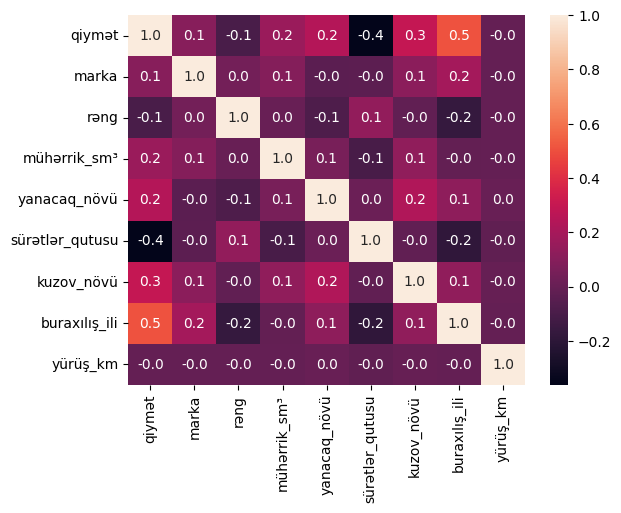

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df.drop(['şəhər', 'valyuta', 'model'], axis = 1).corr(), annot=True, fmt=".1f");

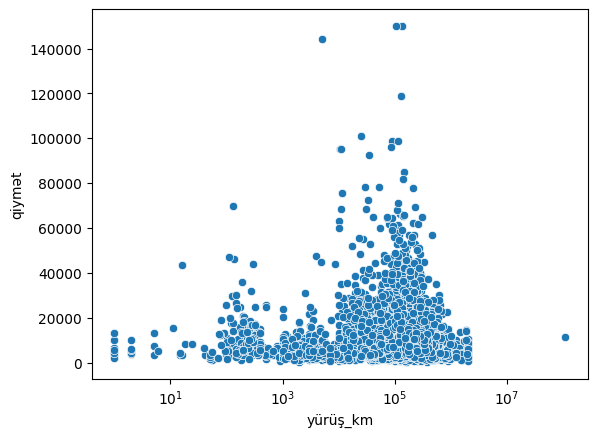

In [51]:
ax = sns.scatterplot(x = 'yürüş_km', y = 'qiymət', data = df);
ax.set(xscale='log');

In [39]:
y = df['qiymət']
X = df.drop(['qiymət', 'valyuta', 'şəhər', 'model'], axis=1)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

In [41]:
import statsmodels.api as sm

lm = sm.OLS(y_train, X_train)
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 qiymət   R-squared (uncentered):               -1536.743
Model:                            OLS   Adj. R-squared (uncentered):          -1538.730
Method:                 Least Squares   F-statistic:                             -773.2
Date:                Sat, 20 May 2023   Prob (F-statistic):                        1.00
Time:                        19:54:50   Log-Likelihood:                         -64932.
No. Observations:                6198   AIC:                                  1.299e+05
Df Residuals:                    6190   BIC:                                  1.299e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
marka              62.0971     10.616      5.849      0.000      41.286      82.908
rəng             -109.9430     31.936     -3.443      0.001    -172.549     -47.337
mühərrik_sm³        0.5776      0.077      7.483      0.000       0.426       0.729
yanacaq_növü     3709.8377    241.687     15.350      0.000    3236.046    4183.629
sürətlər_qutusu -6517.8007    208.755    -31.222      0.000   -6927.033   -6108.569
kuzov_növü       1463.6291     73.374     19.948      0.000    1319.791    1607.467
buraxılış_ili       5.7844      0.137     42.080      0.000       5.515       6.054
yürüş_km           -0.0001   7.66e-05     -1.611      0.107      -0.000    2.68e-05
==============================================================================
Omnibus:                     5920.406   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           468922.632
Skew:                           4.419   Prob(JB):                         0.00
Kurtosis:                      44.685   Cond. No.                     3.21e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.21e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*This model doesn't have a meaning*

In [42]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
model = lm.fit(X_train, y_train)

In [43]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy

y_pred = model.predict(X_test)
r2score = f'R2 Score: {r2_score(y_test, y_pred)}'
mse = f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}'
rmse = f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}'

print(r2score, mse, rmse, sep='\n')

R2 Score: 0.4788110319841383
Mean Squared Error: 43671816.82559639
Root Mean Squared Error: 6608.4655424384555
